Following on lab meeting, 

provide heatmaps with temporal association areas, rescaled

+ reshape all, dissociate each step:
    - plot_heatmap: takes CSV containing id name, sample name, values and the subset of samples and structures wanted (?)
    - fold
    - normalize: take two files: the first with raw_counts used to normalize and the second with raw counts
    - raw counts: take the cells.feather, the list of structure ids, exclude, others
+ all should be done for one cells.feather or for several in parallel

In [1]:
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tools_edmz.process_df import count_cells_by_structure, get_multiple_counts, enrich_df
from tools_edmz.atlas import Atlas

atlas = Atlas()

FOLDER_DATA = "/Users/edmz/data/icm_data/"
FOLDER = FOLDER_DATA + "bulk_corrected/"
paths = [FOLDER + fname for fname in os.listdir(FOLDER)]
path = paths[0]

sample_names = ['Dp114', 'Dp104', 'Ct96', 'Dp105', 'Dp107', 'Ct95', 'Ct81', 'Ct100', 'Ct82', ]
map_path_to_sample_name = dict(zip(paths, sample_names))
map_sample_name_to_path = dict(zip(sample_names, paths))
map_path_to_sample_name

{'/Users/edmz/data/icm_data/bulk_corrected/cells_200316-114.feather': 'Dp114',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-104.feather': 'Dp104',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-96.feather': 'Ct96',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-105.feather': 'Dp105',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-107.feather': 'Dp107',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-95.feather': 'Ct95',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-81.feather': 'Ct81',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-100.feather': 'Ct100',
 '/Users/edmz/data/icm_data/bulk_corrected/cells_200316-82.feather': 'Ct82'}

In [2]:
structures_oi = [
                 353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
                 378, 22, 541, 895, # associative areas
                 909, # entorhinal areas, which are in Retrohippocampal region (822) 
              ]

In [16]:
def count_cells(path: str) -> pd.DataFrame:
    """
    counts cells from one file of type cells.feather
    returns df with columns id, hemisphere, cell_count and one row per structure x hemisphere
    """
    df = pd.read_feather(path)
    df['hemisphere'] = df['hemisphere'].map({0: 'LH', 255: 'RH'})
    counts = (df.groupby(['id', 'hemisphere'], as_index=False)
              .agg(cell_count=('name', 'count'))
              )
    counts = counts.reset_index(drop=True)
    return counts

def group_counts(counts_s: list[pd.DataFrame], sample_names: list[str]) -> pd.DataFrame:
    """
    groups several cell_counts together; sample_names are the names of the samples
    returns df with columns id, hemisphere, and one column per sample
    """
    counts_s = [counts.set_index(['id', 'hemisphere']) for counts in counts_s]
    df = pd.concat(counts_s, axis=1).fillna(0)
    df.columns = sample_names
    df = df.reset_index()
    return df   

def collapse_structures(df: pd.DataFrame, map_collapse: dict[int, int]) -> pd.DataFrame:
    """
    collapses structures according to a dict map_collapse (id -> new_id)
    ids not in map_collapse are kept
    """
    df['id'] = df['id'].map(lambda x: map_collapse.get(x, x))
    counts = (df.groupby(['id', 'hemisphere'], as_index=False)
              .sum()
              )
    return counts

def get_map_to_parent(atlas, parent_ids: list[int]):
    """
    uses annotation graph to map all possible children structures to its parents in parent_ids
    """
    map_parents = atlas.get_map_parents(parent_ids, including_parents=True)
    return map_parents

def filter_df(df: pd.DataFrame, structure_ids: list[int], 
              hemispheres=['RH', 'LH'], exclude: bool=False) -> pd.DataFrame:
    """
    returns a df that includes only the 
    """
    if exclude is False:
        df = df.loc[df["id"].isin(structure_ids) & df["hemisphere"].isin(hemispheres)].reset_index(drop=True)
        return df.copy()
    df = df.loc[~(df["id"].isin(structure_ids) & df["hemisphere"].isin(hemispheres))].reset_index(drop=True)
    return df.copy()

def normalize_df(df: pd.DataFrame, df_normalize: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index(['id', 'hemisphere']).copy()
    df_normalize = df_normalize.set_index(['id', 'hemisphere']).copy()
    normalize_100 = df_normalize.sum(axis=0)
    df = df/normalize_100 * 100
    return df.reset_index()

In [9]:
structures_oi

[353, 337, 345, 369, 361, 378, 22, 541, 895, 909]

In [67]:
pd.read_feather(path)

,x,y,z,size,source,xt,yt,zt,order,id,hemisphere,name,color,volume
0,2067,2793,28,68,9447762.0,179.129444,301.067503,9.368045,305,671,0,"Retrosplenial area, lateral agranular part, la...","[0.10196078431372549, 0.6509803921568628, 0.59...",506453125
1,1943,2434,56,51,525366.0,168.905901,271.725016,14.858921,0,0,0,universe,"[0.0, 0.0, 0.0]",704492906250
2,1749,3458,85,75,14206351.0,153.584850,356.117548,19.011212,193,821,0,"Primary visual area, layer 2/3","[0.03137254901960784, 0.5215686274509804, 0.54...",1999546875
3,1803,3384,85,202,14215504.0,157.673730,349.767000,18.588878,207,41,0,"posteromedial visual area, layer 2/3","[0.03137254901960784, 0.5215686274509804, 0.54...",295046875
4,1757,3197,86,51,15473755.0,153.267501,333.680869,18.855012,206,805,0,"posteromedial visual area, layer 1","[0.03137254901960784, 0.5215686274509804, 0.54...",188656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48449,2415,5211,1776,57,13479489.0,190.082774,468.012311,297.253258,0,0,0,universe,"[0.0, 0.0, 0.0]",704492906250
48450,2418,5231,1776,63,13479900.0,190.395152,469.707243,297.389122,0,0,0,universe,"[0.0, 0.0, 0.0]",704492906250
48451,2813,3031,1776,80,13533866.0,229.959626,298.930550,290.494997,724,1097,255,Hypothalamus,"[0.9019607843137255, 0.26666666666666666, 0.21...",3625484375
48452,2426,5432,1777,58,15072906.0,191.653801,486.714687,298.979141,0,0,0,universe,"[0.0, 0.0, 0.0]",704492906250


In [69]:
structures_oi

[353, 337, 345, 369, 361, 378, 22, 541, 895, 909]

In [ ]:
map_collapse = get_map_to_parent(atlas_clearmap, structures_oi)

In [10]:
# transform cells.feather into cell_count dataframes
counts = [count_cells(path) for path in paths]
# regroup all samples in one table ('id', 'hemisphere' and sample_names)
table = group_counts(counts, sample_names)
# get a map_collapse that maps every child of structures_oi to their parent in structures_oi
atlas_clearmap = Atlas(json_version="clearmap")
map_collapse = get_map_to_parent(atlas_clearmap, structures_oi)
# collapse the count dataframe
collapsed_table = collapse_structures(table, map_collapse)
# keeps only the structures_oi
filtered_table = filter_df(collapsed_table, structures_oi)

# to normalize, keep only cells outside the barrel_field of the right hemisphere
normalize_table = filter_df(collapsed_table, [353, 337, 345, 369, 361,], ['RH'], exclude=True)
# keeps only the structures_oi
normalize_table = filter_df(normalize_table, structures_oi)

In [11]:
# normalize filtered_table by df
normalized_table = normalize_df(filtered_table, normalize_table)

In [12]:
# finally, get the correct annotation
normalized_table = enrich_df(normalized_table)
normalized_table

,id,hemisphere,Dp114,Dp104,Ct96,Dp105,Dp107,Ct95,Ct81,Ct100,Ct82,name,acronym
0,22,LH,12.590892,6.218711,8.458235,3.535184,7.618879,14.014449,6.513216,8.225307,3.966072,Posterior parietal association areas,PTLp
1,22,RH,0.395459,0.278828,0.056712,0.053767,0.167934,0.447542,0.177058,0.344155,0.170162,Posterior parietal association areas,PTLp
2,337,LH,1.543564,4.072580,1.280078,0.658646,0.998763,2.039512,0.708233,2.707353,4.301160,"Primary somatosensory area, lower limb",SSp-ll
3,337,RH,0.357188,0.523859,0.396986,0.262114,0.212127,0.338853,0.303529,0.688310,0.235608,"Primary somatosensory area, lower limb",SSp-ll
4,345,LH,0.216864,0.678059,0.299765,0.591438,0.194449,0.300492,0.240293,0.367099,0.115186,"Primary somatosensory area, mouth",SSp-m
5,345,RH,0.204108,0.040134,0.121526,0.087371,0.053032,0.153443,0.012647,0.390042,0.039268,"Primary somatosensory area, mouth",SSp-m
6,353,LH,0.204108,2.583384,0.469902,5.443914,0.203288,0.645739,0.480587,0.562120,0.756564,"Primary somatosensory area, nose",SSp-n
7,353,RH,0.153081,0.204896,0.064814,0.342765,0.106063,0.262132,0.000000,0.539176,0.028797,"Primary somatosensory area, nose",SSp-n
8,361,LH,12.284730,5.280835,13.149153,1.129108,3.402864,7.007225,5.400278,6.745440,11.403440,"Primary somatosensory area, trunk",SSp-tr
9,361,RH,0.255135,0.589341,0.145832,0.120976,0.150256,0.294099,0.151764,0.608007,1.489568,"Primary somatosensory area, trunk",SSp-tr


### Plot heatmap

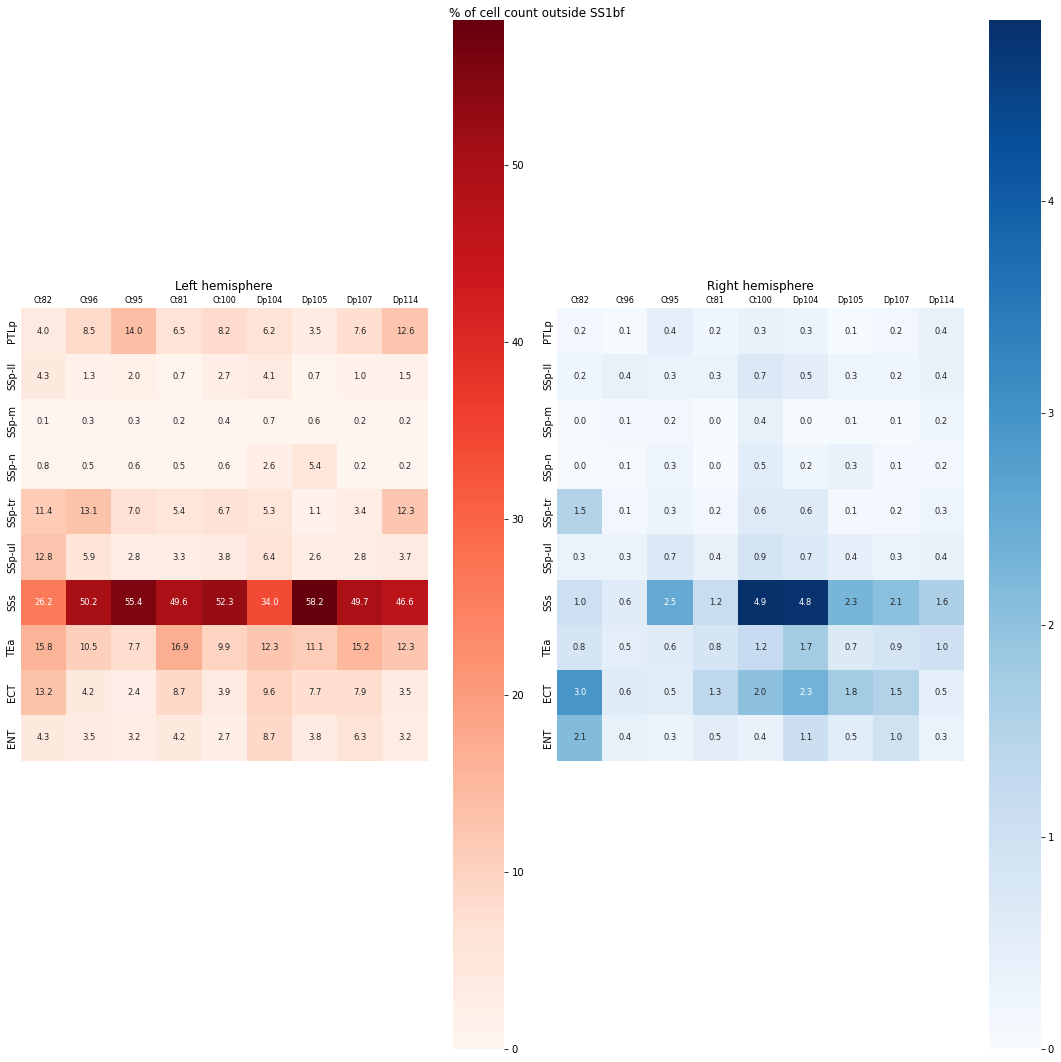

In [72]:
def plot_heatmap(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    """
    Changed it for additional keywords
    """
    sns.heatmap(data=df[sample_names],
                square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
                #vmax=150,  ### Tweek that 
                vmin=0,     ### Tweek that 
                annot=True,
                fmt='.1f',
                annot_kws=dict(fontsize='small')
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=8)
    plt.gca().tick_params(axis='y', labelsize=10)
    if use_ylabels is False:
        plt.gca().set_yticklabels([]);

fig, axs = plt.subplots(1,2, figsize=(15, 15)) ### Tweek that 
axs = axs.flat

plt.sca(next(axs))
plot_heatmap(normalized_table.query("hemisphere == 'LH'").head(50), sample_names_ordered, "Reds" )
plt.title('Left hemisphere')

plt.sca(next(axs))
plot_heatmap(normalized_table.query("hemisphere == 'RH'").head(50), sample_names_ordered,  "Blues", )
plt.title('Right hemisphere')

plt.suptitle('% of cell count outside SS1bf')
plt.tight_layout()

plt.savefig('toto.svg')

In [ ]:
sample_names_ordered = ['Ct82', 'Ct96', 'Ct95', 'Ct81', 'Ct100', 'Dp104', 'Dp105', 'Dp107', 'Dp114' ]
fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs = axs.flat

plt.sca(next(axs))
plot_heatmap(table.query("hemisphere == 'LH'"), sample_names_ordered, "Reds" )
plt.title('Left hemisphere')

plt.sca(next(axs))
plot_heatmap(table.query("hemisphere == 'RH'"), sample_names_ordered,  "Blues", )
plt.title('Right hemisphere')

plt.suptitle('Raw cell count')
plt.tight_layout()

In [71]:
normalized_table.to_csv('toto.csv')

In [28]:
sample_names_ordered

['Ct82', 'Ct96', 'Ct95', 'Ct81', 'Ct100', 'Dp104', 'Dp105', 'Dp107', 'Dp114']

In [30]:
gp_1 = ['Ct82', 'Ct96', 'Ct95', 'Ct81', 'Ct100', ]
gp_2 = ['Dp104', 'Dp105', 'Dp107', 'Dp114']

In [36]:
normalized_table['mean_gp_1'] = normalized_table[gp_1].mean(axis=1)
normalized_table['std_gp_1'] = normalized_table[gp_1].std(axis=1)
normalized_table['mean_gp_2'] = normalized_table[gp_2].mean(axis=1)
normalized_table['std_gp_2'] = normalized_table[gp_2].std(axis=1)

In [37]:
normalized_table

,id,hemisphere,Dp114,Dp104,Ct96,Dp105,Dp107,Ct95,Ct81,Ct100,Ct82,name,acronym,mean_gp_1,std_gp_1,mean_gp_2,std_gp_2
0,22,LH,12.590892,6.218711,8.458235,3.535184,7.618879,14.014449,6.513216,8.225307,3.966072,Posterior parietal association areas,PTLp,8.235456,3.695952,7.490916,3.798791
1,22,RH,0.395459,0.278828,0.056712,0.053767,0.167934,0.447542,0.177058,0.344155,0.170162,Posterior parietal association areas,PTLp,0.239126,0.155203,0.223997,0.146659
2,337,LH,1.543564,4.072580,1.280078,0.658646,0.998763,2.039512,0.708233,2.707353,4.301160,"Primary somatosensory area, lower limb",SSp-ll,2.207267,1.393682,1.818388,1.546361
3,337,RH,0.357188,0.523859,0.396986,0.262114,0.212127,0.338853,0.303529,0.688310,0.235608,"Primary somatosensory area, lower limb",SSp-ll,0.392657,0.175309,0.338822,0.137249
4,345,LH,0.216864,0.678059,0.299765,0.591438,0.194449,0.300492,0.240293,0.367099,0.115186,"Primary somatosensory area, mouth",SSp-m,0.264567,0.094797,0.420203,0.250415
5,345,RH,0.204108,0.040134,0.121526,0.087371,0.053032,0.153443,0.012647,0.390042,0.039268,"Primary somatosensory area, mouth",SSp-m,0.143385,0.149459,0.096161,0.074675
6,353,LH,0.204108,2.583384,0.469902,5.443914,0.203288,0.645739,0.480587,0.562120,0.756564,"Primary somatosensory area, nose",SSp-n,0.582982,0.120184,2.108674,2.490452
7,353,RH,0.153081,0.204896,0.064814,0.342765,0.106063,0.262132,0.000000,0.539176,0.028797,"Primary somatosensory area, nose",SSp-n,0.178984,0.225986,0.201701,0.102339
8,361,LH,12.284730,5.280835,13.149153,1.129108,3.402864,7.007225,5.400278,6.745440,11.403440,"Primary somatosensory area, trunk",SSp-tr,8.741107,3.341746,5.524384,4.815977
9,361,RH,0.255135,0.589341,0.145832,0.120976,0.150256,0.294099,0.151764,0.608007,1.489568,"Primary somatosensory area, trunk",SSp-tr,0.537854,0.564102,0.278927,0.214808


In [76]:
atlas = Atlas(json_version="clearmap").df[['acronym', 'name', 'parent_structure_id']].to_csv('atlas_clearmap.csv')

In [75]:
atlas.df[['acronym', 'name', 'parent_structure_id']].to_csv('atlas.csv')

In [60]:
data = normalized_table.set_index(["id", "hemisphere"])[['mean_gp_1', 'mean_gp_2']].stack().to_frame().reset_index()
data.head()

,id,hemisphere,level_2,0
0,22,LH,mean_gp_1,8.235456
1,22,LH,mean_gp_2,7.490916
2,22,RH,mean_gp_1,0.239126
3,22,RH,mean_gp_2,0.223997
4,337,LH,mean_gp_1,2.207267


<AxesSubplot:xlabel='id', ylabel='0'>

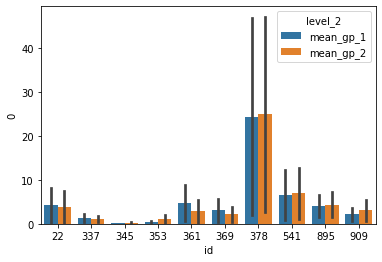

In [63]:
sns.barplot(data=data, x='id', y=0, hue="level_2", )

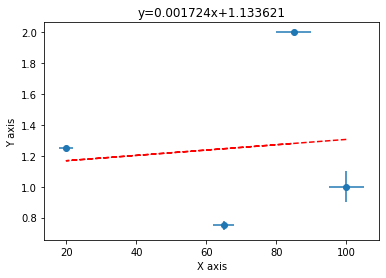

In [38]:
x=np.array([100,65,20,85])
xerr=np.array([5,3,2,5])
y=np.array([1,0.75,1.25,2])
yerr=np.array([0.1,0.03,0.01,0])


fig, ax = plt.subplots()


ax.errorbar(x, y,
            xerr=xerr,
            yerr=yerr,
            fmt='o')


ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Test Code')


z = np.polyfit(x.flatten(), y.flatten(), 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title("y=%.6fx+%.6f"%(z[0],z[1])) 

plt.show()

In [13]:
def plot_heatmap_ax(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    sns.heatmap(data=df[sample_names],
                square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=6)
    plt.gca().tick_params(axis='y', labelsize=7)
    if use_ylabels is False:
        plt.gca().set_yticklabels([])
        
def plot_heatmap_fig(df, sample_names):
    fig, axs = plt.subplots(1,2, figsize=(15, 10))
    axs = axs.flat

    plt.sca(next(axs))
    plot_heatmap_ax(df.query("hemisphere == 'LH'"), sample_names_ordered, "Reds" )
    plt.title('Left hemisphere')

    plt.sca(next(axs))
    plot_heatmap_ax(df.query("hemisphere == 'RH'"), sample_names_ordered,  "Blues", )
    plt.title('Right hemisphere')

    plt.suptitle('Normalized by outside count')
    plt.tight_layout()

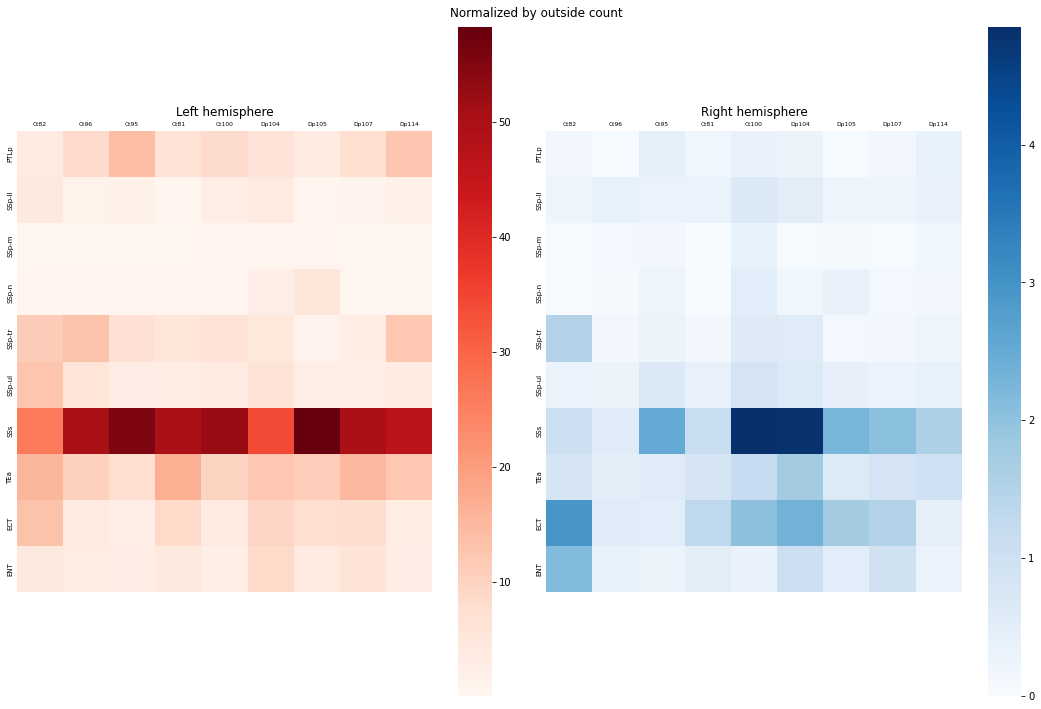

In [15]:
sample_names_ordered = ['Ct82', 'Ct96', 'Ct95', 'Ct81', 'Ct100', 'Dp104', 'Dp105', 'Dp107', 'Dp114' ]
plot_heatmap_fig(normalized_table, sample_names_ordered)

In [20]:
counts_s = [count_cells_by_structure(path, structures_oi) for path in paths]
table = enrich_df(get_multiple_counts(counts_s, sample_names))
table = table.set_index('id').loc[structures_oi].reset_index()
table.head(3)

,id,hemisphere,Dp114,Dp104,Ct96,Dp105,Dp107,Ct95,Ct81,Ct100,Ct82,name,acronym
0,353.0,LH,16,1223,58,810,23,101,38.0,49,289,"Primary somatosensory area, nose",SSp-n
1,353.0,RH,12,97,8,51,12,41,0.0,47,11,"Primary somatosensory area, nose",SSp-n
2,337.0,LH,121,1928,158,98,113,319,56.0,236,1643,"Primary somatosensory area, lower limb",SSp-ll


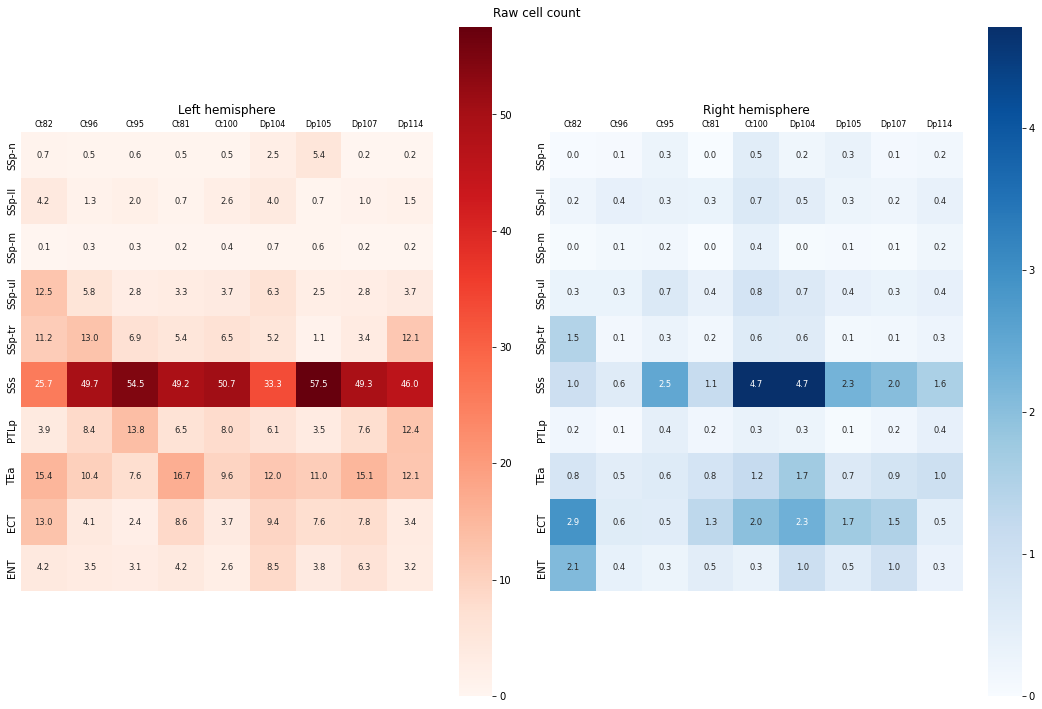

In [25]:
sample_names_ordered = ['Ct82', 'Ct96', 'Ct95', 'Ct81', 'Ct100', 'Dp104', 'Dp105', 'Dp107', 'Dp114' ]
fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs = axs.flat

plt.sca(next(axs))
plot_heatmap(table.query("hemisphere == 'LH'"), sample_names_ordered, "Reds" )
plt.title('Left hemisphere')

plt.sca(next(axs))
plot_heatmap(table.query("hemisphere == 'RH'"), sample_names_ordered,  "Blues", )
plt.title('Right hemisphere')

plt.suptitle('Raw cell count')
plt.tight_layout()

In [26]:
def normalize_counts(counts, ids_normalization, hemispheres_normalization, exclude=False):
    """
    """
    counts = counts.copy().set_index(['id', 'hemisphere'])
    normalize_100 = counts.loc[(ids_normalization, hemispheres_normalization), :].sum().values[0]
    if exclude:
        normalize_100 = counts.sum().values[0] - normalize_100
    counts = counts/normalize_100 * 100
    counts = counts.reset_index()
    return counts

In [27]:
ids_normalization = [981, 201, 1047, 1070, 1038, 1062,]
hemispheres_normalization = ['LH']

norm_counts_s = [normalize_counts(counts, 
                                  ids_normalization=ids_normalization, 
                                  hemispheres_normalization=hemispheres_normalization, 
                                  exclude=True) for counts in counts_s]
table = enrich_df(get_multiple_counts(norm_counts_s, sample_names))
table = table.set_index('id').loc[structures_oi].reset_index()
table.head(3)

,id,hemisphere,Dp114,Dp104,Ct96,Dp105,Dp107,Ct95,Ct81,Ct100,Ct82,name,acronym
0,353.0,LH,0.201359,2.532144,0.465116,5.378486,0.201613,0.634701,0.476609,0.545293,0.740969,"Primary somatosensory area, nose",SSp-n
1,353.0,RH,0.151019,0.200832,0.064154,0.338645,0.105189,0.257651,0.000000,0.523036,0.028203,"Primary somatosensory area, nose",SSp-n
2,337.0,LH,1.522779,3.991801,1.267041,0.650730,0.990533,2.004650,0.702371,2.626308,4.212496,"Primary somatosensory area, lower limb",SSp-ll


In [ ]:
def normalize_counts(counts, ids_normalization, hemispheres_normalization, exclude=False):
    """
    """
    counts = counts.copy().set_index(['id', 'hemisphere'])
    normalize_100 = counts.loc[(ids_normalization, hemispheres_normalization), :].sum().values[0]
    if exclude:
        normalize_100 = counts.sum().values[0] - normalize_100
    counts = counts/normalize_100 * 100
    counts = counts.reset_index()
    return counts

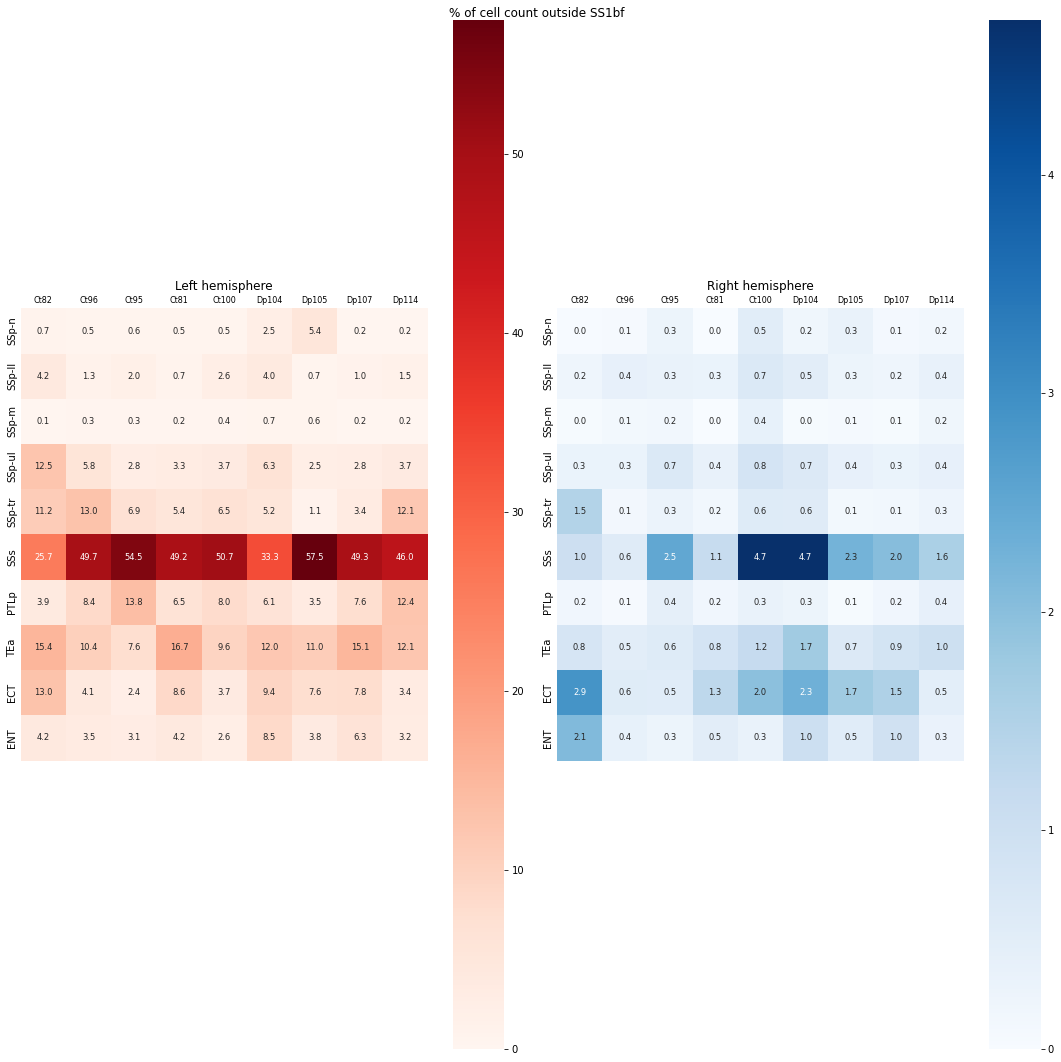

In [28]:
def plot_heatmap(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    """
    Changed it for additional keywords
    """
    sns.heatmap(data=df[sample_names],
                square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
                #vmax=150,
                vmin=0,
                annot=True,
                fmt='.1f',
                annot_kws=dict(fontsize='small')
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=8)
    plt.gca().tick_params(axis='y', labelsize=10)
    if use_ylabels is False:
        plt.gca().set_yticklabels([]);

fig, axs = plt.subplots(1,2, figsize=(15, 15))
axs = axs.flat

plt.sca(next(axs))
plot_heatmap(table.query("hemisphere == 'LH'").head(50), sample_names_ordered, "Reds" )
plt.title('Left hemisphere')

plt.sca(next(axs))
plot_heatmap(table.query("hemisphere == 'RH'").head(50), sample_names_ordered,  "Blues", )
plt.title('Right hemisphere')

plt.suptitle('% of cell count outside SS1bf')
plt.tight_layout()